## Simulación de la ecuación de onda

Vamos a intentar simular la ecuación de onda

$$ \frac{\partial^2}{\partial^2 t}u(x, t) = c^2 \frac{\partial^2}{\partial x^2}u(x, t) $$ 

Usando la funcion tradicional $d_t(x)$ y las propiedades de la Transformada de Fourier con respecto a la convolución. Dejando nuestra ecuación de la siguiente forma 

$$ \frac{\partial^2 }{\partial^2 t}\hat{u}(\omega, t) = c^2 \cdot \hat{d_t}(\omega) \cdot \hat{u}(\omega, t) $$


Donde cada punto $\omega$ se puede interpretar como su propia ecuación diferencial de primer orden. Esto es lo que usarmeos para resolver este problema.

Ahora, para resolver esta ecuación diferencial, que es de segundo orden, podemos resolverla simplemente así o podemos simplificarlo a un sistema de ecuaciones diferenciales de primer orden, dejando el sistema

$$ \begin{cases} 
    \frac{\partial}{\partial t}\hat{u}(\omega, t) = \hat{v}(\omega, t) \\
    \frac{\partial}{\partial t}\hat{v}(\omega, t) = c^2 \cdot \hat{d_t}(\omega) \cdot \hat{u}(\omega, t)
\end{cases} $$

Por lo tanto, ahora podriamos representar este sistema como matrices 

$$ 
    \begin{bmatrix} 
        \frac{\partial}{\partial t}\hat{u}(\omega, t) \\
        \frac{\partial}{\partial t}\hat{v}(\omega, t) \\
    \end{bmatrix}
    =
    \left(\begin{bmatrix} 
        0 && 1 \\
        0 && 0 \\
    \end{bmatrix} \cdot 1 
    + 
    \begin{bmatrix} 
        0 && 0 \\
        c^2 && 0 \\
    \end{bmatrix} 
    \cdot 
    \hat{d_t}(\omega) \right) 
    \cdot
    \begin{bmatrix} 
        \hat{u}(\omega, t) \\
        \hat{v}(\omega, t) \\
    \end{bmatrix} 
$$

Donde vemos que tenemos dos matrices de coeficientes, ya que hay dos funciones o kernels, para conformar este sistema de ecuaciones.

### Seteando el espacio
Vamos a crear el espacio, su transformación y la transformación de la aproximación tradicional.

In [182]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import cm as cm

In [183]:
radio = 100 * np.pi
cantidadPuntos = 1001
x = np.linspace(-radio, radio, cantidadPuntos, dtype = complex)
dx = (2 * radio) / (cantidadPuntos - 1)

Utilizaremos como condición inicial
$$ u(x, t) = A \cdot e^{-i(k\cdot x + \omega \cdot t)} + B \cdot e^{i(k\cdot x + \omega \cdot t)} $$

Con:
 * $A = B = 5$
 * $k = 0.01$
 * $\omega = 0.3$ 

Con la primera condición se puede reducir a: 
$$ u(x, t) = 2A \cdot \cos(k\cdot x + \omega \cdot t) $$

y por lo tanto 
$$ v(x, t) = -2A \cdot \omega \cdot \sin(k\cdot x + \omega \cdot t) $$

In [184]:
velocidad = 30
numeroDeOnda = 0.01
frecuenciaAngular = numeroDeOnda * velocidad
amplitudA = 5
amplitudB = 5
tInicial = 0

primerTermino = amplitudA * np.exp((-1j) * (numeroDeOnda * x + frecuenciaAngular * tInicial))
segundoTermino = amplitudB * np.exp((1j) * (numeroDeOnda * x + frecuenciaAngular * tInicial))

campoU = primerTermino + segundoTermino

campoV = (-1j) * frecuenciaAngular * primerTermino + (1j) * frecuenciaAngular * segundoTermino

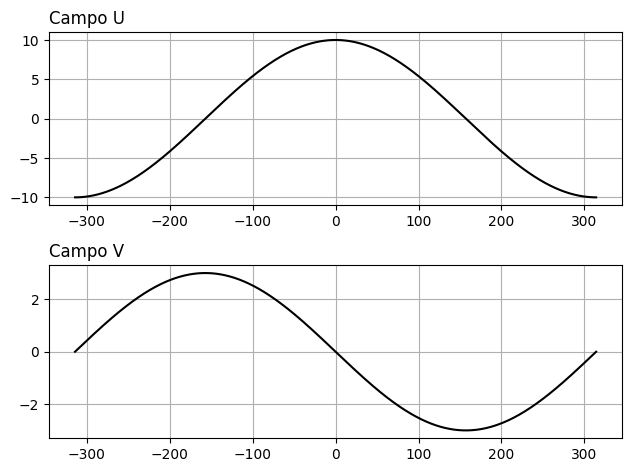

In [185]:
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(x.real, campoU.real, 'k-')
plt.grid(True)
plt.title('Campo U', loc = 'left')
plt.tight_layout(pad=1.0)

plt.subplot(2, 1, 2)
plt.plot(x.real, campoV.real, 'k-')
plt.grid(True)
plt.title('Campo V', loc = 'left')
plt.tight_layout(pad=1.0)

plt.show()

Usando como constate $\left(\frac{\omega}{k} \right)^2 = 900$ y un delta de tiempo $dt = 0.001$

In [186]:
c = frecuenciaAngular / numeroDeOnda
dt = 0.001

Tenemos dos kernels, que llamaremos $\hat{d_{2d}}(\omega)$ y $\hat{d_{0d}}(\omega)$, donde cumplen lo siguiente
$$ f(x) \ast d_{0d}(x) = f(x) $$
$$ f(x) \ast d_{2d}(x) = \frac{d^2}{dx^2}f(x) $$
Por lo tanto estas serían:

In [187]:
def AproximacionTradicional(x, dx, orden):
    largo = len(x)
    puntoMedio = int(np.floor(largo / 2))

    y = np.zeros(largo)
    valores = np.array([4/5, -1/5, 4/105, -1/280])

    for i, valor in enumerate(valores):
        y[puntoMedio + i + 1] = -valor
        y[puntoMedio - i - 1] = valor

    y = np.fft.fft(np.fft.ifftshift(y / dx))
    return (y) ** orden

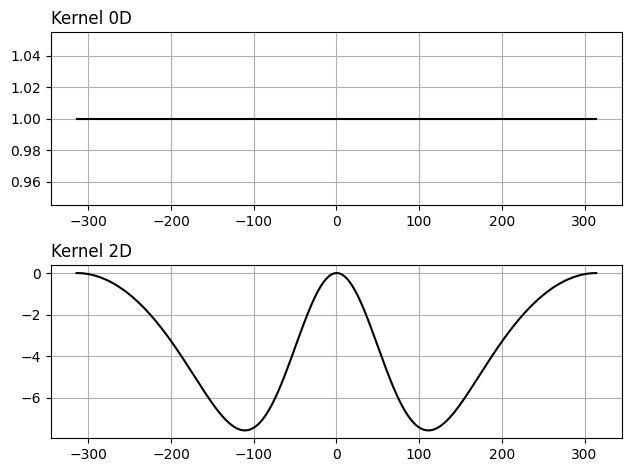

In [188]:
kernel0D = AproximacionTradicional(x, dx, 0)
kernel2D = AproximacionTradicional(x, dx, 2)

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(x.real, kernel0D.real, 'k-')
plt.grid(True)
plt.title('Kernel 0D', loc = 'left')
plt.tight_layout(pad=1.0)

plt.subplot(2, 1, 2)
plt.plot(x.real, kernel2D.real, 'k-')
plt.grid(True)
plt.title('Kernel 2D', loc = 'left')
plt.tight_layout(pad=1.0)

plt.show()

Podemos plantear el sistema de ecuaciones no lineales 
$$ \begin{cases} 
    \frac{\partial}{\partial t} \hat{u}(\omega, t) = \hat{d}_{0D}(\omega) \cdot \hat{v}(\omega, t) \\
    \frac{\partial}{\partial t} \hat{v}(\omega, t) = c^2 \cdot \hat{d}_{2D}(\omega) \cdot \hat{u}(\omega, t) \\
\end{cases} $$

### Simular
Ahora vamos a simular aplicando el método de Runge-Kutta de orden 4 para avanzar la ecuación diferencial.

In [189]:
def Comprimir(vector, otroVector):
  return np.concatenate([vector, otroVector])

def ComprimirCampos(campo, otroCampo):
  return Comprimir(Comprimir(campo.real, campo.imag), Comprimir(otroCampo.real, otroCampo.imag))

def Descomprimir(vector, mitad):
  return vector[:mitad], vector[mitad:]

def DescomprimirCampos(campos):
  campoCombi, otroCampoCombi = Descomprimir(campos, 2 * cantidadPuntos)
  np.shape(campoCombi)

  campoReal, campoImag = Descomprimir(campoCombi, cantidadPuntos)
  otroCampoReal, otroCampoImag = Descomprimir(otroCampoCombi, cantidadPuntos)

  campo = campoReal + (1j) * campoImag
  otroCampo = otroCampoReal + (1j) * otroCampoImag

  return campo, otroCampo

In [190]:
def Transformar(U, V):
  return ComprimirCampos(np.fft.fft(U), np.fft.fft(V))

In [191]:
def Destransformar(transformados):
  uTransformado, vTransformado = DescomprimirCampos(transformados)
  return (np.fft.ifft(uTransformado), np.fft.ifft(vTransformado))

In [192]:
def FuncionIteracion(y, t):
    campoUTransformado, campoVTransformado = DescomprimirCampos(y)
    
    nuevoUTransformado = kernel0D * campoVTransformado
    nuevoVTransformado = (c ** 2) * kernel2D * campoUTransformado

    return ComprimirCampos(nuevoUTransformado, nuevoVTransformado)

In [193]:
cantidadPasos = 30
cantidadIteracionesIntermedias = 150

resultado = np.zeros([cantidadPasos, 2, cantidadPuntos], dtype = complex)

In [194]:
camposTransformados = Transformar(campoU, campoV)
campoUNuevo, campoVNuevo = Destransformar(camposTransformados)
resultado[0, :, :] = [campoUNuevo, campoVNuevo]

for paso in range(1, cantidadPasos):
  
  tiempo = np.arange((paso - 1) * cantidadIteracionesIntermedias * dt, paso * cantidadIteracionesIntermedias * dt, dt)

  solucion = sp.integrate.odeint(FuncionIteracion, camposTransformados, tiempo)

  camposTransformados = solucion[-1]
  campoUNuevo, campoVNuevo = Destransformar(camposTransformados)
  resultado[paso, :, :] = [campoUNuevo, campoVNuevo]

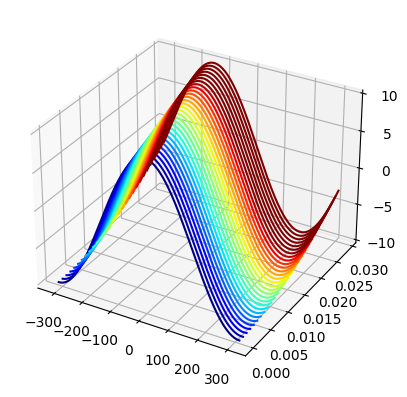

In [195]:
campoAGraficar = 0

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
plt.set_cmap('jet_r')
for j in range(cantidadPasos):
    ys = j * np.ones(cantidadPuntos) * dt
    ax.plot(x.real, ys, np.real(resultado[j, campoAGraficar, :]), color = cm.jet(j * 11))

plt.show()